#Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Change directory to allow imports


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/CMPT 419 720 Project/")
!ls

'=2.0.1'		    output	      testing
'Milestone Report 1.gdoc'   References	      TrackRCNN
'Milestone Report 2.gdoc'   sceneflow	      training
 MonoDepthEstimation	   'synthetic data'  'Weekly Briefings'


#Detectron 2

##Set up GPU and PyTorch

In [ ]:
!pip install pyyaml==5.4.1 pycocotools==2.0.2 imgaug==0.2.6
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
%reload_ext autoreload
%autoreload

     |████████████████████████████████| 645kB 12.9MB/s 
     |████████████████████████████████| 634kB 30.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=bcb7d96bbf775fd091d2d5ecec65e92da6702852d36d839c68163252e374e901
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 660kB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=2911ad9cf0aa9e34121a6613c696aae5db6971b626dab3cca20f891c66bd75d7
  

In [ ]:
!pip3 install torch torchvision

In [ ]:
import torch
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


##Import Libraries

In [ ]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

##Set Directory

In [ ]:
BASE_DIR = '/content/gdrive/My Drive/CMPT 419 720 Project/'
TRAINING_DIR = os.path.join(BASE_DIR, 'training')
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

##Helper Functions

###Mask Creation

In [ ]:
def findfill(image):
    thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    return cv2.fillPoly(image, cnts, [255,255,255])

def make_mask(x, y, w, h, rle):
  mask = np.zeros((h, w, 3), dtype=np.uint8)
  n = len(rle)
  for i in range(0, n, 2):
    o = rle[i] - x
    p = rle[i+1] - y
    mask[p][o] = (255, 255, 255)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = findfill(mask)
  mask = np.expand_dims(mask, 2)
  return mask

def make_pred_mask(pred, w, h):
  pred = pred.permute(1, 2, 0)
  mask = pred.detach().cpu().numpy()
  #print(pred)
  mask[mask < 0] = 0
  mask[mask > 0] = 255
  mask = mask.astype(np.uint8)
  mask = cv2.resize(mask, (h, w), interpolation = cv2.INTER_AREA) 
  return mask

def get_prediction_mask(data):
  data_dirs = os.path.join(BASE_DIR, 'data_name')
  imgs_dir = os.path.join(data_dirs, set_name)
  #h5file = os.path.join(data_dirs, set_name + '.h5')
  #if os.path.isfile(h5file):
  #  with h5py.File(h5file, 'r') as input:
  #    img = np.array(input.get(os.path.basename(data['file_name'])))
  #    input.close()
  #else:
  img = cv2.imread(data['file_name'])
  img_h, img_w = img.shape[:2]
  
  dets = d_predictor(img)['instances'].pred_boxes.tensor.data.cpu().numpy().astype(np.int32)
  pred_mask_t = np.zeros((img_h, img_w, 1), dtype=np.uint8)
  pred_mask_f = np.zeros((img_h, img_w, 1), dtype=np.float32)
  for idx, det in enumerate(dets):
    oh, ow = det[3] - det[1], det[2]-det[0]
    if ow == 0 or oh == 0:
      continue
    cropped = np.array(img[det[1]:det[3], det[0]:det[2]])
    cropped = cv2.resize(cropped, (224, 224), interpolation = cv2.INTER_AREA) 
    cropped = cropped.astype(np.float32)
    cropped /= 255
    input = np.rollaxis(cropped, 2, 0)
    with torch.no_grad():
      input = torch.tensor(input, device=torch.device('cuda'), dtype=torch.float32)
      input = input.unsqueeze(0)
      pred = s_model(input)[0]
    pad_top = (cropped.shape[0] - pred.shape[1])//2
    pad_lef = (cropped.shape[1] - pred.shape[2])//2
    #pred_mask = make_pred_mask(pred, cropped.shape[1], cropped.shape[0], pad_top, pad_lef)
    pred_mask = make_pred_mask(pred, oh, ow)
    pred_mask = np.expand_dims(pred_mask, 2)
    pf = pred_mask.astype(np.float32)
    pred_mask[pred_mask > 0] = idx + 1
    pf[pf > 0] = (idx+1) / len(dets)
    pred_mask_t[det[1]:det[3], det[0]:det[2]] = pred_mask
    pred_mask_f[det[1]:det[3], det[0]:det[2]] = pf

  if 'annotations' in data.keys():
    gt_mask = np.zeros((img_h, img_w, 1), dtype=np.uint8)
    gt_segs = []
    for anno in data['annotations']:
      seg = anno['segmentation']
      bbox = anno['bbox']
      x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
      gt_mask[y:y+h, x:x+w] = make_mask(x, y, w, h, seg[0])
  else:
    gt_mask = None

  pred_mask_tensor = np.rollaxis(pred_mask_f, 2, 0)
  pred_mask_tensor = torch.tensor(pred_mask_tensor, device=torch.device('cuda'), dtype=torch.float32)
  pred_mask_tensor = pred_mask_tensor.unsqueeze(0)

  return img, gt_mask, pred_mask_tensor, pred_mask_t

##Load Images & Annotations

###Annotation Loading & Transcribing

In [ ]:
import pycocotools
import tensorflow as tf
from skimage import measure

class_ids = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person': 4,
    'Cyclist': 5,
    'Tram': 6,
}
def fetch_and_combine_annotations(num_sets=21, poly_from_json=True):
  annotations = {}
  kitti_anno_dir = os.path.join(TRAINING_DIR, 'label_02')
  #tracking_anno_dir = os.path.join(TRAINING_DIR, 'instances_txt')
  tf_anno_dir = os.path.join(TRAINING_DIR, 'instances')
  gps_anno_dir = os.path.join(TRAINING_DIR, 'oxts')
  file_name_template = '0000'
  for s in range(num_sets):
    set_name = file_name_template + str(s)
    set_name = set_name[len(set_name)-4:len(set_name)]
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    #tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
    records = {}

#Load Kitti Annotations
    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      if class_name == 'DontCare' or class_name == 'Misc': #data exclusion
        continue
      frame = int(e[0])
      if frame not in records.keys():
        records[frame] = {}
      obj_id = int(e[1])
      records[frame]['img_id'] = set_name+str(frame)
      records[frame][obj_id] = {
          'class_name': class_name,
          'class_id': class_ids[class_name],
          'alpha': float(e[5]),
          'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
          'xyz': [float(e[10]), float(e[11]), float(e[12])],
          'wlht': [float(e[13]), float(e[14]), float(e[15]), float(e[16])],
      }

#Load GPS Annotations
    gps_anno = open(gps_anno_file, 'r')
    gps_lines = gps_anno.readlines()
    for frame, line in enumerate(gps_lines):
      e = line.split(' ')
      if frame not in records.keys():
        records[frame] = {}
      v = [float(e[8]), float(e[9]), float(e[10])]
      a = [float(e[11]), float(e[12]), float(e[13])]
      records[frame]['dynamics'] = {
          'v': v,
          'a': a,
      }

    #tracking_anno = open(tracking_anno_file, 'r')
    #tracking_lines = tracking_anno.readlines()
    #for line in tracking_lines:
    #  e = line.split(' ')
    #  frame = int(e[0])
    #  class_id = int(e[2])
    #  obj_id = int(e[1])
    #  if frame not in records.keys() or obj_id not in records[frame].keys() or class_id==10: #obj not found
    #    continue
    #  records[frame][obj_id]['height'] = int(e[3])
    #  records[frame][obj_id]['width'] = int(e[4])
    #  rle_obj = {
    #      'counts': e[5],
    #      'size': [int(e[3]), int(e[4])]
    #  }
    #  #records[frame][obj_id]['rle'] = pycocotools._mask._frString(rle_obj)
    #  records[frame][obj_id]['rle'] = rle_obj
    #  records[frame][obj_id]['area'] = pycocotools.mask.area(rle_obj)

#Load Segmentation
    if poly_from_json:
      with open(TRAINING_DIR+'/seg_poly/'+set_name+'.json', 'r') as anno_json:
        imgs_anns = json.load(anno_json)
        for ann in imgs_anns:
          frame = ann['frame']
          obj_id = ann['obj_id']
          records[frame]['height'] = ann['height']
          records[frame]['width'] = ann['width']
          records[frame][obj_id]['poly'] = ann['poly']
      anno_json.close()
    else:
      tf_set_anno_dir = os.path.join(tf_anno_dir, set_name)
      for idx, anno_name in enumerate(os.listdir(tf_set_anno_dir)):
        if not anno_name[0:len(anno_name)-4].isnumeric():
          continue
        frame = int(anno_name[0:len(anno_name)-4])
        if frame not in records.keys():
          continue
        ann_data = tf.io.read_file(os.path.join(tf_set_anno_dir, anno_name))
        ann = tf.image.decode_image(ann_data, dtype=tf.uint16, channels=1).numpy()
        ann = np.squeeze(ann, 2)
        org_ann = ann
        ann = ann % 1000
        height, width = ann.shape[:2]
        records[frame]['height'] = height
        records[frame]['width'] = width
        for obj_id in records[frame].keys():
          if not isinstance(obj_id, int):
            continue
          if obj_id == 0:
            if 1000 in org_ann:
              bit_mask = np.where(org_ann == 1000, 255, 0).astype(np.uint8)
            elif 2000 in org_ann:
              bit_mask = np.where(org_ann == 2000, 255, 0).astype(np.uint8)
            elif 3000 in org_ann:
              bit_mask = np.where(org_ann == 3000, 255, 0).astype(np.uint8)
            elif 4000 in org_ann:
              bit_mask = np.where(org_ann == 4000, 255, 0).astype(np.uint8)
            elif 5000 in org_ann:
              bit_mask = np.where(org_ann == 5000, 255, 0).astype(np.uint8)
            elif 6000 in org_ann:
              bit_mask = np.where(org_ann == 6000, 255, 0).astype(np.uint8)
            elif 7000 in org_ann:
              bit_mask = np.where(org_ann == 7000, 255, 0).astype(np.uint8)
            elif 8000 in org_ann:
              bit_mask = np.where(org_ann == 8000, 255, 0).astype(np.uint8)
            elif 9000 in org_ann:
              bit_mask = np.where(org_ann == 9000, 255, 0).astype(np.uint8)
            else:
              continue
          else:
            bit_mask = np.where(ann == obj_id, 255, 0).astype(np.uint8)

          rle = pycocotools.mask.encode(np.asfortranarray(bit_mask))
          #records[frame][obj_id]['rle'] = rle
          records[frame][obj_id]['poly'] = []
          contours = measure.find_contours(bit_mask, 0.5)
          for contour in contours:
            contour = np.flip(contour, axis=1).astype(int)
            segmentation = contour.ravel().tolist()
            records[frame][obj_id]['poly'].append(segmentation)
          #records[frame][obj_id]['area'] = pycocotools.mask.area(rle).astype(np.int32)

    annotations[set_name] = records
  return annotations

In [ ]:
annotations = fetch_and_combine_annotations()

Annotation Dict Format

* \<scene name (str)\> i.e. '0000', '0001'
  
  * \<frame (int)\>

    * \<img_id (str)\>

      * \<height (int)\>

      * \<width (int)\>

      * \<obj_id (int)\>

        * stuff
    

###Image Loading & Annotation Formating

In [ ]:
def get_detection_data(data_name, set_name, hasAnno=False, fromH5=False):
  data_dirs = os.path.join(BASE_DIR, data_name)
  dataset = []
  imgs_dir = os.path.join(data_dirs, set_name)

  for idx, img_name in enumerate(os.listdir(imgs_dir)):
      record = {}
      filename = os.path.join(imgs_dir, img_name)
      record['file_name'] = filename
      frame = int(img_name[0:len(img_name)-4])
      if frame not in annotations[set_name].keys():
        continue
      record['image_id'] = annotations[set_name][frame]['img_id']
      record['height'] = annotations[set_name][frame]['height']
      record['width'] = annotations[set_name][frame]['width']

      if hasAnno:
        anns = annotations[set_name][frame]   
        objs = []
        for obj_id in anns.keys():
          obj_anno = anns[obj_id]
          if isinstance(obj_id, str) or 'poly' not in obj_anno.keys() or obj_anno['poly']==[]:
            continue
          obj = {
              'image_id': anns['img_id'],
              'bbox': obj_anno['bbox'],
              'bbox_mode': BoxMode.XYXY_ABS,
              'segmentation': obj_anno['poly'],
              #'area': obj_anno['area'],
              'category_id': obj_anno['class_id'],
              'id': obj_id,
          }
          objs.append(obj)
        record['annotations'] = objs
      if hasAnno and len(record['annotations'])==0:
        continue
      dataset.append(record)
  
  return dataset

##Mask RCNN Training

###Traing Set Loading

In [ ]:
d = 'train'
DatasetCatalog.register("seg_" + d, lambda d=d: get_segmentation_data('train', True, True))
MetadataCatalog.get("seg_" + d).set(thing_classes=['car', 'van', 'truck', 'pedestrian', 'person_sitting', 'cyclist', 'tram'])
metadata = MetadataCatalog.get("seg_" + d)

####Visualize

{'file_name': '/content/gdrive/My Drive/CMPT 419 720 Project/training/image_02/0013/000116.png', 'image_id': '0013116', 'height': 375, 'width': 1242, 'annotations': [{'image_id': '0013116', 'bbox': [438.184396, 176.124019, 466.184396, 251.706832], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[459, 249, 458, 249, 457, 249, 456, 249, 455, 249, 454, 249, 453, 249, 453, 248, 453, 247, 453, 246, 453, 245, 453, 244, 452, 244, 452, 243, 452, 242, 452, 241, 452, 240, 452, 239, 452, 238, 452, 237, 452, 236, 452, 235, 452, 234, 451, 234, 451, 233, 451, 232, 451, 231, 450, 231, 449, 232, 449, 233, 449, 234, 449, 234, 448, 235, 448, 236, 448, 236, 447, 237, 447, 238, 447, 238, 446, 239, 446, 239, 445, 240, 445, 241, 445, 241, 444, 242, 444, 243, 444, 244, 444, 245, 444, 246, 445, 246, 445, 247, 445, 248, 445, 248, 444, 248, 443, 248, 442, 248, 442, 247, 442, 246, 441, 246, 441, 245, 441, 244, 441, 243, 441, 242, 441, 241, 441, 240, 441, 239, 441, 238, 441, 237, 442, 236, 442, 236, 442, 235

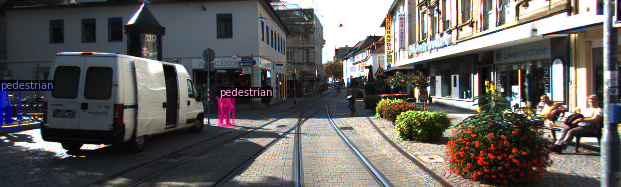

{'file_name': '/content/gdrive/My Drive/CMPT 419 720 Project/training/image_02/0013/000326.png', 'image_id': '0013326', 'height': 375, 'width': 1242, 'annotations': [{'image_id': '0013326', 'bbox': [454.036541, 176.216902, 490.036541, 281.591351], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[468, 280, 467, 280, 467, 279, 466, 279, 465, 279, 465, 278, 464, 278, 463, 278, 463, 277, 462, 277, 462, 276, 462, 275, 462, 274, 462, 273, 462, 272, 462, 271, 462, 270, 462, 269, 461, 269, 461, 268, 461, 267, 461, 266, 461, 265, 461, 264, 460, 264, 460, 263, 460, 262, 460, 261, 460, 260, 460, 259, 460, 258, 460, 257, 460, 256, 460, 255, 460, 254, 460, 253, 461, 252, 461, 252, 461, 251, 462, 250, 462, 250, 462, 249, 462, 248, 462, 247, 461, 247, 461, 246, 461, 245, 461, 244, 460, 244, 460, 243, 460, 242, 460, 241, 459, 241, 459, 240, 459, 239, 458, 239, 458, 238, 458, 237, 458, 236, 457, 236, 457, 235, 457, 234, 457, 233, 457, 232, 458, 231, 458, 231, 458, 230, 458, 229, 458, 228, 458, 227

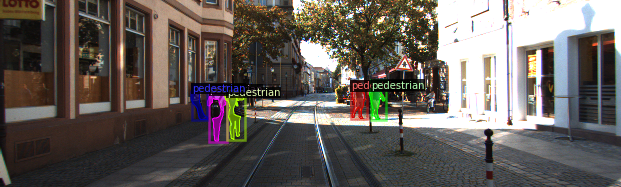

{'file_name': '/content/gdrive/My Drive/CMPT 419 720 Project/training/image_02/0013/000293.png', 'image_id': '0013293', 'height': 375, 'width': 1242, 'annotations': [{'image_id': '0013293', 'bbox': [237.231591, 173.696104, 312.331432, 365.328006], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[263, 360, 262, 360, 261, 360, 260, 360, 259, 360, 258, 360, 257, 360, 256, 360, 255, 360, 254, 360, 253, 360, 253, 359, 252, 359, 251, 359, 250, 359, 249, 359, 249, 358, 248, 358, 247, 358, 246, 358, 246, 357, 245, 357, 245, 356, 244, 356, 244, 355, 244, 354, 245, 353, 245, 353, 246, 352, 247, 352, 247, 352, 248, 351, 249, 351, 250, 351, 250, 351, 251, 350, 252, 350, 252, 350, 253, 349, 254, 349, 254, 349, 255, 348, 256, 348, 256, 348, 257, 347, 258, 347, 258, 347, 258, 346, 259, 345, 259, 345, 259, 344, 260, 343, 260, 343, 260, 342, 260, 341, 259, 341, 259, 340, 259, 339, 259, 338, 259, 337, 259, 336, 259, 335, 259, 334, 259, 333, 259, 332, 259, 331, 259, 330, 259, 329, 258, 329, 258, 328

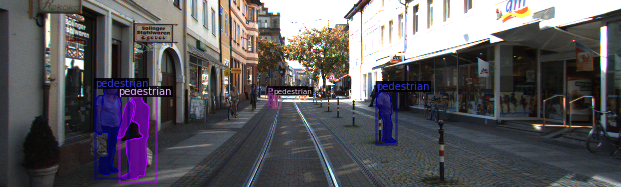

{'file_name': '/content/gdrive/My Drive/CMPT 419 720 Project/training/image_02/0013/000311.png', 'image_id': '0013311', 'height': 375, 'width': 1242, 'annotations': [{'image_id': '0013311', 'bbox': [517.860741, 177.750635, 539.782093, 236.983376], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[533, 234, 532, 234, 531, 234, 530, 234, 530, 233, 530, 232, 530, 231, 529, 231, 529, 230, 529, 229, 529, 228, 529, 227, 529, 226, 529, 225, 528, 225, 528, 224, 528, 223, 528, 222, 527, 222, 526, 222, 525, 223, 525, 224, 525, 225, 525, 226, 525, 227, 525, 228, 525, 229, 525, 230, 525, 231, 525, 232, 525, 233, 525, 233, 524, 234, 524, 234, 523, 234, 522, 234, 521, 234, 521, 233, 520, 233, 521, 232, 521, 232, 521, 231, 521, 230, 522, 229, 522, 229, 522, 228, 522, 227, 522, 226, 522, 225, 522, 224, 521, 224, 521, 223, 521, 222, 521, 221, 521, 220, 521, 219, 521, 218, 521, 217, 521, 216, 521, 215, 521, 214, 521, 213, 520, 213, 520, 212, 520, 211, 520, 210, 520, 209, 520, 208, 520, 207, 520, 206

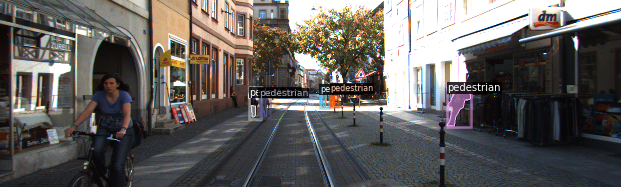

{'file_name': '/content/gdrive/My Drive/CMPT 419 720 Project/training/image_02/0013/000253.png', 'image_id': '0013253', 'height': 375, 'width': 1242, 'annotations': [{'image_id': '0013253', 'bbox': [453.606607, 180.523901, 482.895266, 246.810955], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[471, 245, 470, 245, 469, 245, 468, 245, 467, 245, 467, 244, 466, 244, 466, 243, 466, 242, 465, 242, 465, 241, 465, 240, 464, 240, 464, 239, 464, 238, 464, 237, 464, 236, 464, 235, 464, 234, 464, 233, 464, 232, 464, 231, 463, 231, 463, 230, 463, 229, 463, 228, 463, 227, 463, 226, 463, 225, 462, 225, 462, 224, 462, 223, 462, 222, 462, 221, 462, 220, 462, 219, 462, 218, 462, 217, 462, 216, 462, 215, 463, 214, 463, 214, 463, 213, 464, 212, 464, 212, 464, 211, 465, 210, 465, 210, 465, 209, 465, 208, 466, 207, 466, 207, 466, 206, 466, 205, 466, 204, 466, 203, 466, 202, 465, 202, 464, 202, 464, 201, 463, 201, 462, 202, 462, 202, 461, 202, 460, 202, 459, 202, 460, 201, 460, 201, 460, 200, 461, 199

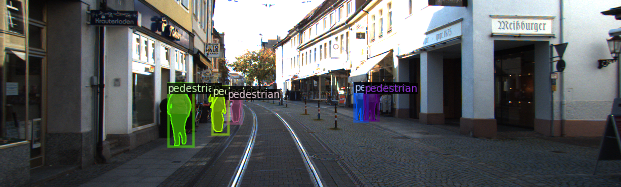

In [ ]:
dataset_dicts = get_detection_data('training/image_02', '0013', True)
for d in random.sample(dataset_dicts, 5):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
  print(d)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

###Training Configs

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("seg_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 

In [ ]:
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
import detectron2.data.transforms as T

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=[
      T.Resize((1024, 1024)),
      T.RandomCrop('absolute', (512, 512)),
      T.RandomBrightness(0.8, 1.2),
      T.RandomContrast(0.6, 1.4),
      T.RandomSaturation(0.8, 1.2),
      T.RandomRotation(angle=[90, 90]),
      T.RandomLighting(0.7),
      T.RandomFlip(prob=0.5),
   ]))

###Train Network

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

#TrackRCNN

In [ ]:
@inproceedings{Voigtlaender19CVPR_MOTS,
 author = {Paul Voigtlaender and Michael Krause and Aljosa Osep and Jonathon Luiten and Berin Balachandar Gnana Sekar and Andreas Geiger and Bastian Leibe},
 title = {{MOTS}: Multi-Object Tracking and Segmentation},
 booktitle = {CVPR},
 year = {2019},
}

##Setup

In [ ]:
!pip install tensorflow-gpu pycocotools numpy scipy sklearn pypng opencv-python munkres

     |████████████████████████████████| 394.3MB 42kB/s 
     |████████████████████████████████| 655kB 42.7MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp37-none-any.whl size=67163 sha256=5a1dcc1494526a5c146fa6a83391fa6dd10952470858f02edd3fec22974ff9e5
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


#Distance Esitmation

##Configs


##Training

##Evaluation

#Output

#1 time helper functions

###Create Masked Images Per Object

In [ ]:
import pycocotools
import tensorflow as tf
from skimage import measure

class_ids = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person': 4,
    'Cyclist': 5,
    'Tram': 6,
}
def isolate_masks_per_object(num_sets=21):
  annotations = {}
  kitti_anno_dir = os.path.join(TRAINING_DIR, 'label_02')
  tracking_anno_dir = os.path.join(TRAINING_DIR, 'instances_txt')
  tf_anno_dir = os.path.join(TRAINING_DIR, 'instances')
  file_name_template = '0000'
  for s in range(1):
    #set_name = file_name_template + str(s)
    #set_name = set_name[len(set_name)-4:len(set_name)]
    set_name = '0020'
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    records = {}

    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      if class_name == 'DontCare' or class_name == 'Misc': #data exclusion
        continue
      frame = int(e[0])
      if frame not in records.keys():
        records[frame] = {}
      obj_id = int(e[1])
      records[frame]['img_id'] = set_name+str(frame);
      records[frame][obj_id] = {
          'class_name': class_name,
          'class_id': class_ids[class_name],
          'alpha': float(e[5]),
          'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
          'xyz': [float(e[10]), float(e[11]), float(e[12])],
          'wlht': [float(e[13]), float(e[14]), float(e[15]), float(e[16])],
      }

    tf_set_anno_dir = os.path.join(tf_anno_dir, set_name)
    for idx, anno_name in enumerate(os.listdir(tf_set_anno_dir)):
      if not anno_name[0:len(anno_name)-4].isnumeric():
        continue
      frame = int(anno_name[0:len(anno_name)-4])
      if frame not in records.keys():
        continue
      ann_data = tf.io.read_file(os.path.join(tf_set_anno_dir, anno_name))
      ann = tf.image.decode_image(ann_data, dtype=tf.uint16, channels=1).numpy()
      ann = np.squeeze(ann, 2)
      org_ann = ann
      ann = ann % 1000
      for obj_id in records[frame].keys():
        if obj_id=='img_id' or obj_id=='height' or obj_id=='width' or obj_id not in ann:
          continue
        if obj_id == 0:
          if 1000 in org_ann:
            bit_mask = np.where(org_ann == 1000, 255, 0).astype(np.uint8)
          elif 2000 in org_ann:
            bit_mask = np.where(org_ann == 2000, 255, 0).astype(np. uint8)
          elif 3000 in org_ann:
            bit_mask = np.where(org_ann == 3000, 255, 0).astype(np.uint8)
          elif 4000 in org_ann:
            bit_mask = np.where(org_ann == 4000, 255, 0).astype(np.uint8)
          elif 5000 in org_ann:
            bit_mask = np.where(org_ann == 5000, 255, 0).astype(np.uint8)
          elif 6000 in org_ann:
            bit_mask = np.where(org_ann == 6000, 255, 0).astype(np.uint8)
          elif 7000 in org_ann:
            bit_mask = np.where(org_ann == 7000, 255, 0).astype(np.uint8)
          elif 8000 in org_ann:
            bit_mask = np.where(org_ann == 8000, 255, 0).astype(np.uint8)
          elif 9000 in org_ann:
            bit_mask = np.where(org_ann == 9000, 255, 0).astype(np.uint8)
          else:
            continue
        else:
          bit_mask = np.where(ann == obj_id, 255, 0).astype(np.uint8)
        ###
        bit_mask_outdir = TRAINING_DIR+'/isolate_obj_mask/'+str(set_name)+'/'+str(obj_id)+'/'
        os.makedirs(bit_mask_outdir, exist_ok=True)
        os.chdir(bit_mask_outdir)
        bit_mask_name = str(frame)+'.png'
        cv2.imwrite(bit_mask_name, bit_mask)
        ###

isolate_masks_per_object()

KeyboardInterrupt: ignored

###Save Small Bitmasks as H5

In [ ]:
import h5py
from PIL import Image
import numpy as np

mask_input_dir = os.path.join(TRAINING_DIR, 'isolate_obj_mask_small')
h5_output_dir = os.path.join(TRAINING_DIR, 'isolate_obj_mask_small_h5')

for set_name in os.listdir(mask_input_dir):
  set_dir = os.path.join(mask_input_dir, set_name)
  h5_set_dir = os.path.join(h5_output_dir, set_name)
  for obj_id in os.listdir(set_dir):
    obj_dir = os.path.join(set_dir, obj_id)
    h5_obj_dir = os.path.join(h5_set_dir, obj_id)
    os.makedirs(h5_obj_dir, exist_ok=True)
    for frame in os.listdir(obj_dir):
      frame_path = os.path.join(obj_dir, frame)
      frame_data = np.asarray(Image.open(frame_path)).astype(np.uint8)
      os.chdir(h5_obj_dir)
      print(h5_obj_dir)
      print(frame[0:len(frame)-4]+'.h5')
      with h5py.File(frame[0:len(frame)-4]+'.h5', 'w') as hf:
        hf.create_dataset("bitmask",  data=frame_data)

###Write Resized Masks (224, 224)

In [ ]:
from google.colab.patches import cv2_imshow

def create_resized_masks(num_sets=21, dsize=(224, 224)):
  isolate_mask_dir = os.path.join(TRAINING_DIR, 'isolate_obj_mask')
  #for set_name in os.listdir(isolate_mask_dir):
  set_name = '0020'
  set_dir = os.path.join(isolate_mask_dir, set_name)
  for obj_id in os.listdir(set_dir):
    obj_dir = os.path.join(set_dir, obj_id)
    for frame in os.listdir(obj_dir):
      bit_mask = cv2.imread(os.path.join(obj_dir, frame))
      small_bit_mask = cv2.resize(bit_mask, dsize)
      outdir = TRAINING_DIR+'/isolate_obj_mask_small/'+str(set_name)+'/'+str(obj_id)+'/'
      os.makedirs(outdir, exist_ok=True)
      os.chdir(outdir)
      small_name = str(frame)
      cv2.imwrite(small_name, small_bit_mask)

create_resized_masks()

In [ ]:
  isolate_mask_dir = os.path.join(TRAINING_DIR, 'isolate_obj_mask_small')
  for set_name in os.listdir(isolate_mask_dir):
    print(set_name)
    set_dir = os.path.join(isolate_mask_dir, set_name)
    for obj_id in os.listdir(set_dir):
      obj_dir = os.path.join(set_dir, obj_id)
      for frame in os.listdir(obj_dir):
        dir = TRAINING_DIR+'/isolate_obj_mask_small/'+str(set_name)+'/'+str(obj_id)+'/'
        #os.chdir(dir)
        #src = frame  #find out the file name which u want to rename using indexing
        #dst = frame[0:len(frame)-4]        #change it to the destination name
        #os.rename(src, dst)     #rename it 

0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0000
0001
0002
0003
0004
0005
0006
0020


##Write New Segmentation Polys

In [ ]:
import json

for set_name in annotations.keys():
  #print(annotations[set_name][0])
  #print(type(annotations[set_name][0][0]['area']))
  with open('/content/gdrive/My Drive/CMPT 419 720 Project/training/seg_poly/'+set_name+'.json', 'w') as outfile:
    poly_annos = []
    for frame in annotations[set_name].keys():
      for obj_id in annotations[set_name][frame].keys():
        if isinstance(obj_id, int) and 'poly' in annotations[set_name][frame][obj_id]:
          anno = {
              'frame': frame,
              'obj_id': obj_id,
              'height': annotations[set_name][frame]['height'],
              'width': annotations[set_name][frame]['width'],
              'poly': annotations[set_name][frame][obj_id]['poly'],
              #'area': annotations[set_name][frame][obj_id]['area'],
          }
          poly_annos.append(anno)
    json.dump(poly_annos, outfile)
    outfile.close()


#Experimental

##Bypass object identification/segmentation/tracking

Let's experiment with 1 frame look back, 

relative velocity known; segmentation & object tracking known & isolated

###Load in annotations with obj_id first

In [ ]:
import pycocotools
import tensorflow as tf
from skimage import measure

class_ids = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person': 4,
    'Cyclist': 5,
    'Tram': 6,
}
def obj_id_first_annotations(num_sets=21, poly_from_json=True):
  annotations = {}
  kitti_anno_dir = os.path.join(TRAINING_DIR, 'label_02')
  tf_anno_dir = os.path.join(TRAINING_DIR, 'instances')
  gps_anno_dir = os.path.join(TRAINING_DIR, 'oxts')
  file_name_template = '0000'
  for s in range(num_sets):
    set_name = file_name_template + str(s)
    set_name = set_name[len(set_name)-4:len(set_name)]
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
    records = {}

#Load GPS Annotations
    gps_anno = open(gps_anno_file, 'r')
    gps_lines = gps_anno.readlines()
    gps = {}
    for frame, line in enumerate(gps_lines):
      e = line.split(' ')
      v = [float(e[8]), float(e[9]), float(e[10])]
      a = [float(e[11]), float(e[12]), float(e[13])]
      gps[frame] = {
          'v': v,
          'a': a,
      }

#Load Kitti Annotations
    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      if class_name == 'DontCare' or class_name == 'Misc': #data exclusion
        continue
      frame = int(e[0])
      obj_id = int(e[1])
      if obj_id not in records.keys():
        records[obj_id] = {}
      if frame not in records[obj_id].keys():
        records[obj_id][frame] = {}
      records[obj_id]['class_name'] = class_name
      records[obj_id][frame] = {
          'img_id': set_name+str(frame),
          'class_name': class_name,
          'class_id': class_ids[class_name],
          'alpha': float(e[5]),
          'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
          'xyz': [float(e[10]), float(e[11]), float(e[12])],
          'wlht': [float(e[13]), float(e[14]), float(e[15]), float(e[16])],
          'v': gps[frame]['v'],
          'a': gps[frame]['a'],
      }

#Load Segmentation
    if poly_from_json:
      with open(TRAINING_DIR+'/seg_poly/'+set_name+'.json', 'r') as anno_json:
        imgs_anns = json.load(anno_json)
        for ann in imgs_anns:
          frame = ann['frame']
          obj_id = ann['obj_id']
          records[obj_id][frame]['height'] = ann['height']
          records[obj_id][frame]['width'] = ann['width']
          records[obj_id][frame]['poly'] = ann['poly']
      anno_json.close()

    annotations[set_name] = records
  return annotations

In [ ]:
obj_first_annotations = obj_id_first_annotations()

###Cherry Pick Datasets

Requirements: has to have more than 2 or more frames

In [ ]:
def cherry_pick_data(annotations, lookback=1, class_targets=None, class_excludes=None):
  cherrypicked = {}
  for scene in annotations.keys():
    cherrypicked[scene] = {}
    for obj_id in annotations[scene].keys():
      frames = annotations[scene][obj_id].keys()
      class_name = annotations[scene][obj_id]['class_name']
      if len(frames)-1 < lookback+1 or (class_targets != None and class_name not in class_targets) or (class_excludes != None and class_name in class_excludes):
        continue
      cherrypicked[scene][obj_id] = annotations[scene][obj_id]
  return cherrypicked

###Construct pairwise annotations

Pair Frame 1 with Frame 2

Camera records at 10 frames per second: 0.1s between each frame.

Velocity in the direction toward the object of interest is therefore (dist2 - dist1)/0.1

NOTE: this is reducing the problem to the object being stationary

In [ ]:
import math
import numpy as np

def dist(xyz):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    return math.sqrt(x**2+y**2+z**2)

##predict displacement with forward euler
def dynamic_disp(v1, v2, a1, a2, t=0.1, h=0.001):
  ad = (a2-a1)/t
  d = 0
  v = v1
  a = a1
  for t in range(int(t/h)):
    a = a + h*ad
    v = v + h*a
    d += v*h + 0.5*a*h**2
  return d

def pairwise_bitmask(annotations):
  pair_wise_anno = []
  mask_dir = os.path.join(TRAINING_DIR, 'isolate_obj_mask_small')
  for scene in annotations.keys():
    for obj_id in annotations[scene].keys():
      frames = list(annotations[scene][obj_id].keys())
      frames.remove('class_name')
      for f in range(len(frames)-1):
        frame1 = annotations[scene][obj_id][frames[f]]
        frame2 = annotations[scene][obj_id][frames[f+1]]
        filename1 = mask_dir+'/'+scene+'/'+str(obj_id)+'/'+str(frames[f])+'.png'
        filename2 = mask_dir+'/'+scene+'/'+str(obj_id)+'/'+str(frames[f+1])+'.png'
        if not (os.path.exists(filename1) and os.path.exists(filename2)):
          continue
        xd = -dynamic_disp(frame1['v'][1], frame2['v'][1], frame1['a'][1], frame2['a'][1])
        yd = -dynamic_disp(frame1['v'][2], frame2['v'][2], frame1['a'][2], frame2['a'][2])
        zd = dynamic_disp(frame1['v'][0], frame2['v'][0], frame1['a'][0], frame2['a'][0])
        disp = [xd, yd, zd]
        distance = dist(frame2['xyz'])
        pair = {
            'input': {
                'filename1': filename1,
                'filename2': filename2,
                'disp': disp,
            },
            'output': distance,
        }
        pair_wise_anno.append(pair)
  return pair_wise_anno

height = 375
width = 1242
def pairwise_bbox(annotations):
  pair_wise_anno = []
  for scene in annotations.keys():
    for obj_id in annotations[scene].keys():
      frames = list(annotations[scene][obj_id].keys())
      frames.remove('class_name')
      for f in range(len(frames)-1):
        frame1 = annotations[scene][obj_id][frames[f]]
        frame2 = annotations[scene][obj_id][frames[f+1]]      
        xd = -dynamic_disp(frame1['v'][1], frame2['v'][1], frame1['a'][1], frame2['a'][1])
        yd = -dynamic_disp(frame1['v'][2], frame2['v'][2], frame1['a'][2], frame2['a'][2])
        zd = dynamic_disp(frame1['v'][0], frame2['v'][0], frame1['a'][0], frame2['a'][0])
        disp = [xd, yd, zd]
        distance = dist(frame2['xyz'])
        input = {
                'bbox1': [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height],
                'bbox2': [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height],
                'disp': disp,
            }
        pair = {
            'input': np.array(input['bbox1'] + input['bbox2'] + input['disp']).astype(np.float32),
            'output': np.array(distance).astype(np.float32),
        }
        pair_wise_anno.append(pair)
  return pair_wise_anno

###BBOX

####Load & Seperate Dataset

#####Mono-class, GT train & test (deprecated)

In [ ]:
#import random
#random.seed()

#anno = cherry_pick_data(obj_first_annotations,class_target='Car')
#dataset = pairwise_bbox(anno)
# 50% training, 10% validation, 40% testing
#train_input = []
#train_output = []
#valid_input = []
#valid_output = []
#test_input = []
#test_output = []
#for d in dataset:
#  r = random.uniform(0, 1)
#  if r < 0.5:
#    train_input.append(torch.from_numpy(d['gt_input']))
#    train_output.append(torch.from_numpy(d['output']))
#  elif r < 0.6:
#    valid_input.append(torch.from_numpy(d['gt_input']))
#    valid_output.append(torch.from_numpy(d['output']))
#  else:
#    test_input.append(torch.from_numpy(d['gt_input']))
#    test_output.append(torch.from_numpy(d['output']))

#print("training: {} entries".format(len(train_input)))
#print("validation: {} entries".format(len(valid_input)))
#print("testing: {} entries".format(len(test_input)))

training: 13228 entries
validation: 2743 entries
testing: 10750 entries


#####Mono-Class train & test

In [ ]:
import random
random.seed()

targets = ['Car']
anno = cherry_pick_data(obj_first_annotations,class_targets=targets)
dataset = pairwise_bbox(anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in dataset:
  r = random.uniform(0, 1)
  if r < 0.5:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  elif r < 0.6:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))
  else:
    test_input.append(torch.from_numpy(d['input']))
    test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 13428 entries
validation: 2709 entries
testing: 10584 entries


#####CarPed Multi

In [ ]:
import random
random.seed()

targets = ['Car', 'Pedestrian']
anno = cherry_pick_data(obj_first_annotations,class_targets=targets)
dataset = pairwise_bbox(anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in dataset:
  r = random.uniform(0, 1)
  if r < 0.5:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  elif r < 0.6:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))
  else:
    test_input.append(torch.from_numpy(d['input']))
    test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 19107 entries
validation: 3796 entries
testing: 15121 entries


#####Multi-Class train & test

In [ ]:
import random
random.seed()

anno = cherry_pick_data(obj_first_annotations)
dataset = pairwise_bbox(anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in dataset:
  r = random.uniform(0, 1)
  if r < 0.5:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  elif r < 0.6:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))
  else:
    test_input.append(torch.from_numpy(d['input']))
    test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 22865 entries
validation: 4666 entries
testing: 18039 entries


#####Mono-class train, multi-class test; dynamics train, gt test (deprecated)

In [ ]:
#import random
#random.seed()

#mono_anno = cherry_pick_data(obj_first_annotations,class_target='Car')
#train_dataset = pairwise_bbox(mono_anno)
#multi_anno = cherry_pick_data(obj_first_annotations)
#test_dataset = pairwise_bbox(multi_anno)
# 50% training, 10% validation, 40% testing
#train_input = []
#train_output = []
#valid_input = []
#valid_output = []
#test_input = []
#test_output = []
#for d in train_dataset:
#  r = random.uniform(0, 1)
#  if r < 0.9:
#    train_input.append(torch.from_numpy(d['pr_input']))
#    train_output.append(torch.from_numpy(d['output']))
#  else:
#    valid_input.append(torch.from_numpy(d['pr_input']))
#    valid_output.append(torch.from_numpy(d['output']))
#
#for d in test_dataset:
#  test_input.append(torch.from_numpy(d['gt_input']))
#  test_output.append(torch.from_numpy(d['output']))

#print("training: {} entries".format(len(train_input)))
#print("validation: {} entries".format(len(valid_input)))
#print("testing: {} entries".format(len(test_input)))

training: 24030 entries
validation: 2691 entries
testing: 45570 entries


#####Mono-class train, Mono-None-Class test

In [ ]:
import random
random.seed()

train_targets = ['Car']
car_anno = cherry_pick_data(obj_first_annotations, class_targets=train_targets)
train_dataset = pairwise_bbox(car_anno)
test_targets = ['Pedestrian']
ped_anno = cherry_pick_data(obj_first_annotations, class_targets=test_targets)
test_dataset = pairwise_bbox(ped_anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in train_dataset:
  r = random.uniform(0, 1)
  if r < 0.9:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  else:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))

for d in test_dataset:
  test_input.append(torch.from_numpy(d['input']))
  test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 24006 entries
validation: 2715 entries
testing: 11303 entries


#####Mono-Class train, Multi-None-Class test

In [ ]:
import random
random.seed()

train_targets = ['Car']
anno = cherry_pick_data(obj_first_annotations, class_targets=train_targets)
train_dataset = pairwise_bbox(anno)
non_anno = cherry_pick_data(obj_first_annotations, class_excludes=train_targets)
test_dataset = pairwise_bbox(non_anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in train_dataset:
  r = random.uniform(0, 1)
  if r < 0.9:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  else:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))

for d in test_dataset:
  test_input.append(torch.from_numpy(d['input']))
  test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 24090 entries
validation: 2631 entries
testing: 18849 entries


#####Model Contamination

In [ ]:
import random
random.seed()

train_targets = ['Car']
car_anno = cherry_pick_data(obj_first_annotations, class_targets=train_targets)
car_dataset = pairwise_bbox(car_anno)
test_targets = ['Pedestrian']
ped_anno = cherry_pick_data(obj_first_annotations, class_targets=test_targets)
ped_dataset = pairwise_bbox(ped_anno)
# 50% training, 10% validation, 40% testing
ped_t
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in train_dataset:
  r = random.uniform(0, 1)
  if r < 0.9:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  else:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))

  test_input.append(torch.from_numpy(d['input']))
  test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 34150 entries
validation: 3874 entries
testing: 26721 entries


#####'Sub-One' Class train, 'One' class test

In [ ]:
import random
random.seed()

excluded = ['Cyclist']
anno = cherry_pick_data(obj_first_annotations, class_excludes=excluded)
train_dataset = pairwise_bbox(anno)
non_anno = cherry_pick_data(obj_first_annotations, class_targets=excluded)
test_dataset = pairwise_bbox(non_anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in train_dataset:
  r = random.uniform(0, 1)
  if r < 0.9:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  else:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))

for d in test_dataset:
  test_input.append(torch.from_numpy(d['input']))
  test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 39310 entries
validation: 4359 entries
testing: 1901 entries


####Network

Configs

In [ ]:
n_epochs = 25

Network Definition

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BBoxDistNet(nn.Module):
  def __init__(self):
    super(BBoxDistNet, self).__init__()

    self.fc_net = nn.Sequential(
      nn.Linear(11, 16),
      nn.LayerNorm(16),
      nn.ReLU(inplace=True),
      nn.Linear(16, 32),
      nn.LayerNorm(32),
      nn.ReLU(inplace=True),
      nn.Linear(32, 64),
      nn.LayerNorm(64),
      nn.ReLU(inplace=True),
      nn.Linear(64, 32),
      nn.LayerNorm(32),
      nn.ReLU(inplace=True),
      nn.Linear(32, 1),
    )
  def forward(self, x):
    x = self.fc_net(x)
    return x

net = BBoxDistNet().cuda()

optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

Training

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] training_loss: 0.186
validation_loss: 1.296
[2] training_loss: 0.227
validation_loss: 1.321
[3] training_loss: 0.232
validation_loss: 1.324
[4] training_loss: 0.245
validation_loss: 1.323
[5] training_loss: 0.245
validation_loss: 1.318
[6] training_loss: 0.256
validation_loss: 1.327
[7] training_loss: 0.255
validation_loss: 1.326
[8] training_loss: 0.271
validation_loss: 1.342
[9] training_loss: 0.266
validation_loss: 1.307
[10] training_loss: 0.252
validation_loss: 1.261
[11] training_loss: 0.260
validation_loss: 1.323
[12] training_loss: 0.269
validation_loss: 1.371
[13] training_loss: 0.282
validation_loss: 1.322
[14] training_loss: 0.278
validation_loss: 1.351
[15] training_loss: 0.326
validation_loss: 1.323
[16] training_loss: 0.255
validation_loss: 1.308
[17] training_loss: 0.262
validation_loss: 1.380
[18] training_loss: 0.249
validation_loss: 1.448
[19] training_loss: 0.328
validation_loss: 1.414
[20] training_loss: 0.429
validation_loss: 1.303
[21] training_loss: 0.264
val

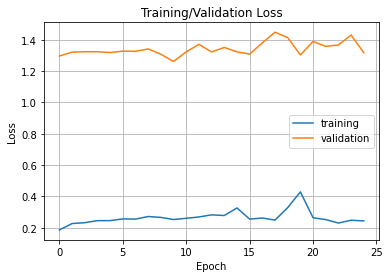

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
for epoch in range(n_epochs):
  running_loss = 0
  for i in range(len(train_input)):
    input = Variable(train_input[i].cuda())
    target = Variable(train_output[i].cuda())
    optimizer.zero_grad()
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
  running_loss/=len(train_input)
  train_losses.append(running_loss)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  valid_loss = 0
  for i in range(len(valid_input)):
    input = valid_input[i].cuda()
    target = valid_output[i].cuda()
    output = net(input)
    loss = criterion(output, target)
    valid_loss += loss.item()

  valid_loss /= len(valid_input)
  valid_losses.append(valid_loss)
  print('validation_loss: %.3f' %(valid_loss))

epochs = [x for x in range(n_epochs)]
fig, ax = plt.subplots()
ax.plot(epochs, np.array(train_losses), label='training')
ax.plot(epochs, np.array(valid_losses), label='validation')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training/Validation Loss')
ax.grid()
ax.legend()
plt.show()

Testing

In [ ]:
mean_error = 0
mean_dist = 0
for i in range(len(test_input)):
  input = Variable(test_input[i].cuda())
  target = test_output[i].item()
  mean_dist += target
  output = net(input).item()
  mean_error += math.sqrt((target-output)**2)
mean_error /= len(test_input)
print('mean test absolute error: %.3f' %(mean_error))
mean_dist /= len(test_input)
print('mean test relative error: %.3f' %(mean_error/mean_dist))

mean test absolute error: 0.395
mean test relative error: 0.088


###Bit Mask

####Flatten Inputs (deprecated)

In [ ]:
#import torch.nn as nn
#from PIL import Image
#
#def flatten_bitmask(data):
#  fname1 = data['filename1']
#  fname2 = data['filename2']
#  disp = np.array(data['disp']).astype(np.float32)
#  image1 = np.array(Image.open(fname1)).astype(np.float32) / 255
#  image2 = np.array(Image.open(fname2)).astype(np.float32) / 255
#  flat1 = image1.flatten()
#  flat2 = image1.flatten()
#  input = np.append(np.append(flat1, flat2), disp)
#  tensor = torch.from_numpy(input)
#  return tensor

####Load & Seperate Dataset

#####Mono-Class train & test

In [ ]:
import random
random.seed()

targets = ['Car']
anno = cherry_pick_data(obj_first_annotations,class_targets=targets)
dataset = pairwise_bitmask(anno)
# 50% training, 10% validation, 40% testing
train = []
valid = []
test = []
for d in dataset:
  k = random.uniform(0, 1)
  if k < 0.8:
    continue
  r = random.uniform(0, 1)
  if r < 0.5:
    train.append(d)
  elif r < 0.6:
    valid.append(d)
  else:
    test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 2266 entries
validation: 492 entries
testing: 1918 entries


#####Multi-Class train & test

In [ ]:
import random
random.seed()

anno = cherry_pick_data(obj_first_annotations)
dataset = pairwise_bitmask(anno)
# 50% training, 10% validation, 40% testing
train = []
valid = []
test = []
for d in dataset:
  r = random.uniform(0, 1)
  if r < 0.5:
    train.append(d)
  elif r < 0.6:
    valid.append(d)
  else:
    test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 14655 entries
validation: 2838 entries
testing: 11547 entries


#####Mono-Class train, Mono-Other-Class test

In [ ]:
import random
random.seed()

car_anno = cherry_pick_data(obj_first_annotations,class_targets=['Car'])
ped_anno = cherry_pick_data(obj_first_annotations,class_targets=['Pedestrian'])
train_dataset = pairwise_bitmask(car_anno)
test_dataset = pairwise_bitmask(ped_anno)

train = []
valid = []
test = []
for d in train_dataset:
  k = random.uniform(0, 1)
  if k < 0.8:
    continue
  r = random.uniform(0, 1)
  if r < 0.9:
    train.append(d)
  else:
    valid.append(d)

for d in test_dataset:
  test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 4242 entries
validation: 496 entries
testing: 5357 entries


#####Model Contamination

In [ ]:
import random
random.seed()

car_anno = cherry_pick_data(obj_first_annotations,class_targets=['Car', 'Pedestrian'])
ped_anno = cherry_pick_data(obj_first_annotations,class_targets=['Car'])
train_dataset = pairwise_bitmask(car_anno)
test_dataset = pairwise_bitmask(ped_anno)

train = []
valid = []
test = []
for d in train_dataset:
  k = random.uniform(0, 1)
  if k < 0.8:
    continue
  r = random.uniform(0, 1)
  if r < 0.9:
    train.append(d)
  else:
    valid.append(d)

for d in test_dataset:
  if k < 0.8:
    continue
  test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 5191 entries
validation: 566 entries
testing: 0 entries


####Network

Configs

In [ ]:
n_epochs = 10

Network Definition

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BitmaskDistNet2D(nn.Module): #VGG16
  def __init__(self):
    super(BitmaskDistNet2D, self).__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
    self.conv15 = nn.Conv2d(64, 64, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv25 = nn.Conv2d(128, 128, 3, padding=1)
    self.bnorm2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv35 = nn.Conv2d(256, 256, 3, padding=1)
    self.bnorm3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv45 = nn.Conv2d(512, 512, 3, padding=1)
    self.bnorm4 = nn.BatchNorm2d(512)

  def forward(self, x):
    x = F.relu(self.bnorm1(self.conv1(x)))
    x = F.relu(self.bnorm1(self.conv15(x)))
    x = self.pool(x)

    x = F.relu(self.bnorm2(self.conv2(x)))
    x = F.relu(self.bnorm2(self.conv25(x)))
    x = self.pool(x)

    x = F.relu(self.bnorm3(self.conv3(x)))
    x = F.relu(self.bnorm3(self.conv35(x)))
    x = F.relu(self.bnorm3(self.conv35(x)))
    x = self.pool(x)

    x = F.relu(self.bnorm4(self.conv4(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = self.pool(x)
   
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = self.pool(x)

    x = torch.flatten(x)

    return x

class BitmaskDistNet1D(nn.Module): #VGG16
  def __init__(self):
    super(BitmaskDistNet1D, self).__init__()
    self.fc_net = nn.Sequential(
      nn.Linear(50179, 4096),
      nn.LayerNorm(4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, 4096),
      nn.LayerNorm(4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, 1),
    )

  def forward(self, x):
    x = self.fc_net(x)
    return x

net2D1 = BitmaskDistNet2D().cuda()
net2D2 = BitmaskDistNet2D().cuda()
net1D = BitmaskDistNet1D().cuda()
optimizer2D1 = optim.Adam(net2D1.parameters())
optimizer2D2 = optim.Adam(net2D2.parameters())
optimizer1D = optim.Adam(net1D.parameters())
criterion = nn.MSELoss()

Training

#####Batch(sucks)

In [ ]:
###Batch Loader
def batch_loader(file_names):
  image = tf.io.read_file(file_names[0])
  batch_np = tf.image.decode_image(image, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224)
  i = 1
  while i < batch_size:
    image = tf.io.read_file(file_names[i])
    image_np = tf.image.decode_image(image, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224)
    batch_np = np.append(batch_np, image_np, axis=0)
    i += 1
  tensor = torch.from_numpy(batch_np)
  return tensor

In [ ]:
random.seed()
torch.cuda.empty_cache()
for epoch in range(n_epochs):
  running_loss = 0
  random.shuffle(train)
  b = 0
  while b+batch_size < len(train):
    input_f1 = []
    input_f2 = []
    input_ds = []
    targets = []
    for i in range(batch_size):
      element = train[i+b]
      input_f1.append(element['input']['filename1'])
      input_f2.append(element['input']['filename2'])
      input_ds.append(element['input']['disp'])
      targets.append(element['output'])
    input1 = Variable(batch_loader(input_f1).cuda())
    input2 = Variable(batch_loader(input_f2).cuda())
    disps = np.array(input_ds, dtype=np.float32)
    targets = Variable(torch.from_numpy(np.array(targets)).cuda())
    
    optimizer2D1.zero_grad()
    optimizer2D2.zero_grad()
    optimizer1D.zero_grad()
    inter1 = net2D1(input1)
    inter2 = net2D2(input2)
    inter1 = inter1.cpu().numpy()
    inter2 = inter2.cpu().numpy()
    c_input = Variable(tf.concat([c_input,disps], 1))
    output = net1D(c_input)
    loss = criterion(output, target)
    loss.backward()
    optimizer1D.step()
    optimizer2D1.step()
    optimizer2D2.step()
    running_loss += loss.item()
    b+=batch_size
    
  running_loss/=len(train//batch_size)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  error = 0
  for i in range(len(valid_input)):
    try:
      input = Variable(flatten_bitmask(valid_input[i]).cuda())
    except FileNotFoundError:
      continue
    target = valid_output[i].item()
    output = net(input).item()
    error += math.sqrt((target-output)**2)
  print('mean validation error: %.3f' %(error/len(valid_input)))

NameError: ignored

#####Indv

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] training_loss: 0.156
validation_loss: 1.054
[2] training_loss: 0.194
validation_loss: 0.947
[3] training_loss: 0.215
validation_loss: 0.954
[4] training_loss: 0.246
validation_loss: 0.945
[5] training_loss: 0.259
validation_loss: 0.956
[6] training_loss: 0.272
validation_loss: 0.949
[7] training_loss: 0.272
validation_loss: 0.945
[8] training_loss: 0.284
validation_loss: 0.940
[9] training_loss: 0.276
validation_loss: 0.940
[10] training_loss: 0.299
validation_loss: 0.949
[11] training_loss: 0.325
validation_loss: 0.936
[12] training_loss: 0.316
validation_loss: 0.935
[13] training_loss: 0.321
validation_loss: 0.924
[14] training_loss: 0.304
validation_loss: 0.915
[15] training_loss: 0.277
validation_loss: 0.908
[16] training_loss: 0.296
validation_loss: 0.916
[17] training_loss: 0.282
validation_loss: 0.917
[18] training_loss: 0.286
validation_loss: 0.912
[19] training_loss: 0.290
validation_loss: 0.909
[20] training_loss: 0.276
validation_loss: 0.904


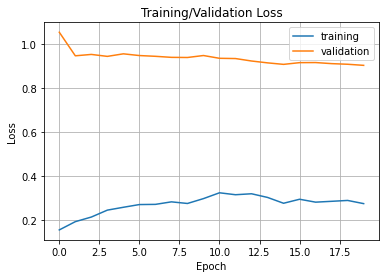

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
for epoch in range(n_epochs):
  running_loss = 0
  for data in train:
    image1 = tf.io.read_file(data['input']['filename1'])
    tensor1 = torch.from_numpy(tf.image.decode_image(image1, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input1 = Variable(tensor1.cuda())
    image2 = tf.io.read_file(data['input']['filename2'])
    tensor2 = torch.from_numpy(tf.image.decode_image(image2, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input2 = Variable(tensor2.cuda())
    disp = np.array(data['input']['disp'], dtype=np.float32)
    target = Variable(torch.from_numpy(np.array(data['output']).astype(np.float32)).cuda())
    
    optimizer2D1.zero_grad()
    optimizer2D2.zero_grad()
    optimizer1D.zero_grad()
    inter1 = net2D1(input1)
    inter2 = net2D2(input2)
    inter1 = inter1.cpu().detach().numpy()
    inter2 = inter2.cpu().detach().numpy()
    c_input = np.append(inter1, inter2)
    c_input = np.append(c_input, disp)
    c_input = c_input.astype(np.float32)
    c_input = Variable(torch.from_numpy(c_input).cuda())
    output = net1D(c_input)
    loss = criterion(output, target)
    loss.backward()
    optimizer1D.step()
    optimizer2D1.step()
    optimizer2D2.step()
    running_loss += loss.item()
    
  running_loss /= len(train)
  train_losses.append(running_loss)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  valid_loss = 0
  for data in valid:
    image1 = tf.io.read_file(data['input']['filename1'])
    tensor1 = torch.from_numpy(tf.image.decode_image(image1, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input1 = Variable(tensor1.cuda())
    image2 = tf.io.read_file(data['input']['filename2'])
    tensor2 = torch.from_numpy(tf.image.decode_image(image2, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input2 = Variable(tensor2.cuda())
    disp = np.array(data['input']['disp'], dtype=np.float32)
    target = Variable(torch.from_numpy(np.array(data['output']).astype(np.float32)).cuda())

    inter1 = net2D1(input1)
    inter2 = net2D2(input2)
    inter1 = inter1.cpu().detach().numpy()
    inter2 = inter2.cpu().detach().numpy()
    c_input = np.append(inter1, inter2)
    c_input = np.append(c_input, disp)
    c_input = c_input.astype(np.float32)
    c_input = Variable(torch.from_numpy(c_input).cuda())
    output = net1D(c_input)
    loss = criterion(output, target)
    valid_loss += loss.item()
  valid_loss /= len(valid)
  valid_losses.append(valid_loss)
  print('validation_loss: %.3f' %(valid_loss))

epochs = [x for x in range(n_epochs)]
fig, ax = plt.subplots()
ax.plot(epochs, np.array(train_losses), label='training')
ax.plot(epochs, np.array(valid_losses), label='validation')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training/Validation Loss')
ax.grid()
ax.legend()
plt.show()

Testing

In [ ]:
mean_error = 0
mean_dist = 0
for data in test:
  image1 = tf.io.read_file(data['input']['filename1'])
  tensor1 = torch.from_numpy(tf.image.decode_image(image1, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
  input1 = Variable(tensor1.cuda())
  image2 = tf.io.read_file(data['input']['filename2'])
  tensor2 = torch.from_numpy(tf.image.decode_image(image2, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
  input2 = Variable(tensor2.cuda())
  disp = np.array(data['input']['disp'], dtype=np.float32)
  target = data['output']

  inter1 = net2D1(input1)
  inter2 = net2D2(input2)
  inter1 = inter1.cpu().detach().numpy()
  inter2 = inter2.cpu().detach().numpy()
  c_input = np.append(inter1, inter2)
  c_input = np.append(c_input, disp)
  c_input = c_input.astype(np.float32)
  c_input = Variable(torch.from_numpy(c_input).cuda())
  output = net1D(c_input)

  mean_dist += target
  mean_error += math.sqrt((target-output)**2)

mean_error /= len(test)
print('mean test absolute error: %.3f' %(mean_error))
mean_dist /= len(test)
print('mean test relative error: %.3f' %(mean_error/mean_dist))

mean test absolute error: 0.692
mean test relative error: 0.172
